# Whole cell vs nuclei comparisons

This notebook contains analyses related to examining rabies barcode dynamics using whole cell and nuclei dissociations w/ our nuclei-thethered barcoding strategy.

Input for this notebook requires:
1) Pooled embedding coordinates w/ metadata from 10_transcriptome_visualization
2) Rabies barcode matrices for datasets c1-c4 and n1-n4

Output for this notebook includes:
1) Plots related to number of rabies barcodes in pooled whole cell and nuclei data
2) Plots related to cell type distributions between datasets

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was last amended by Maddie Urbanek on 12/12/2025

## Notebook set-up

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
from scipy.stats import ranksums
import os
import math
from scipy.stats import binomtest
from scipy.stats import entropy
from scipy.stats import binom

pd.options.mode.chained_assignment = None
import scanpy as sc
import anndata as ad


In [2]:
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/')

## Import datasets

### Load-in paired slice rabies experiments

In [3]:
#Rabies
c1=pd.read_table('./barcode_count_matrices/c1_completecounts.tsv',delimiter='\t')
c1['datasetid']='c1'
c1['CBC'] = c1['CBC'].str.replace("'", "")
c1['CBC'] = c1['CBC'].str.replace('b', 'c1_')
c1['barcode'] = 'c1_' + c1['barcode']

c2=pd.read_table('./barcode_count_matrices/c2_completecounts.tsv',delimiter='\t')
c2['datasetid']='c2'
c2['CBC'] = c2['CBC'].str.replace("'", "")
c2['CBC'] = c2['CBC'].str.replace('b', 'c2_')
c2['barcode'] = 'c2_' + c2['barcode']

n1=pd.read_table('./barcode_count_matrices/n1_completecounts.tsv',delimiter='\t')
n1['datasetid']='n1'
n1['CBC'] = n1['CBC'].str.replace("'", "")
n1['CBC'] = n1['CBC'].str.replace('b', 'n1_')
n1['barcode'] = 'n1_' + n1['barcode']

n2=pd.read_table('./barcode_count_matrices/n2_completecounts.tsv',delimiter='\t')
n2['datasetid']='n2'
n2['CBC'] = n2['CBC'].str.replace("'", "")
n2['CBC'] = n2['CBC'].str.replace('b', 'n2_')
n2['barcode'] = 'n2_' + n2['barcode']

c3=pd.read_table('./barcode_count_matrices/c3_completecounts.tsv',delimiter='\t')
c3['datasetid']='c3'
c3['CBC'] = c3['CBC'].str.replace("'", "")
c3['CBC'] = c3['CBC'].str.replace('b', 'c3_')
c3['barcode'] = 'c3_' + c3['barcode']

c4=pd.read_table('./barcode_count_matrices/c4_completecounts.tsv',delimiter='\t')
c4['datasetid']='c4'
c4['CBC'] = c4['CBC'].str.replace("'", "")
c4['CBC'] = c4['CBC'].str.replace('b', 'c4_')
c4['barcode'] = 'c4_' + c4['barcode']

n3=pd.read_table('./barcode_count_matrices/n3_completecounts.tsv',delimiter='\t')
n3['datasetid']='n3'
n3['CBC'] = n3['CBC'].str.replace("'", "")
n3['CBC'] = n3['CBC'].str.replace('b', 'n3_')
n3['barcode'] = 'n3_' + n3['barcode']

n4=pd.read_table('./barcode_count_matrices/n4_completecounts.tsv',delimiter='\t')
n4['datasetid']='n4'
n4['CBC'] = n4['CBC'].str.replace("'", "")
n4['CBC'] = n4['CBC'].str.replace('b', 'n4_')
n4['barcode'] = 'n4_' + n4['barcode']

#Final barcode matrices across all experiments are concatenated into one large dataframe
barcodes_df=pd.concat([c1,c2,c3,c4,n1,n2,n3,n4], ignore_index=True, axis=0)
barcodes_df

,CBC,barcode,UMI_Count,datasetid
0,c1_ATCTATTGCATCAGGA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,6,c1
1,c1_AGGGAGTCAAGGCCTG,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
2,c1_ACCTCATACCTTCATA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
3,c1_CATAATTGCATCAGGA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
4,c1_CACCAGAAACCAACAG,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
...,...,...,...,...
29564918,n4_CCACCCTTCCGAAAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564919,n4_CCTCAATGACCACAGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564920,n4_AAGGAGGGAGCAACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564921,n4_AGAGCAATCACGACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...,1,n4


### Load in metadata from transcriptomic analysis

In [4]:
metadata=pd.read_table('./transcriptome/filtered_assignments.csv',delimiter=',')

#Split metadata into cell and nuc lists for separate plotting
cell_datasets=['c1','c2','c3','c4']
cell_metadata = metadata.loc[metadata['datasetid'].isin(cell_datasets)]
nuc_datasets=['n1','n2','n3','n4']
nuc_metadata = metadata.loc[metadata['datasetid'].isin(nuc_datasets)]

### Remove rabies barcode entries that don't correspond to cells passing transcriptome

In [5]:
real_nuc = barcodes_df.loc[barcodes_df['CBC'].isin(nuc_metadata['cellbarcode'])]
real_cell = barcodes_df.loc[barcodes_df['CBC'].isin(cell_metadata['cellbarcode'])]

In [6]:
print('Total number of unique barcode:cell combinations')
print(len(real_cell))
print()
print('Total number of unique barcode:nuc combinations')
print(len(real_nuc))

Total number of unique barcode:cell combinations
1487035

Total number of unique barcode:nuc combinations
591512


## Capture comparisons

To compare barcode capture dynamics in the paired cell vs. nuc datasets, plot:

1) The distribution of Log10(UMI Counts for every barcode per cell)
2) The distribution of Log10(summed barcode UMIs for every cell)
3) Log10(Total UMIs) vs. Log10(Unique barcodes per cell) post-barcode thresholding

### Log10(UMI counts for every barcode per cell)

Get some stats on the distribution:

In [7]:
nuc_dist = real_nuc['UMI_Count']
cell_dist = real_cell['UMI_Count']

print('Nuc mean:')
print(nuc_dist.mean())
print('Nuc median:')
print(nuc_dist.median())
print('Nuc SEM:')
print(nuc_dist.sem())
print('Cell mean:')
print(cell_dist.mean())
print('Cell median:')
print(cell_dist.median())
print('Cell SEM:')
print(cell_dist.sem())

print('Wilcoxon Ranked Sum Results:')
print(ranksums(nuc_dist, cell_dist))

Nuc mean:
1.1494745668726924
Nuc median:
1.0
Nuc SEM:
0.004209569630871344
Cell mean:
1.6357180564008245
Cell median:
1.0
Cell SEM:
0.01081810007059194
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-108.52868337980281, pvalue=0.0)


Plot distribution comparison:

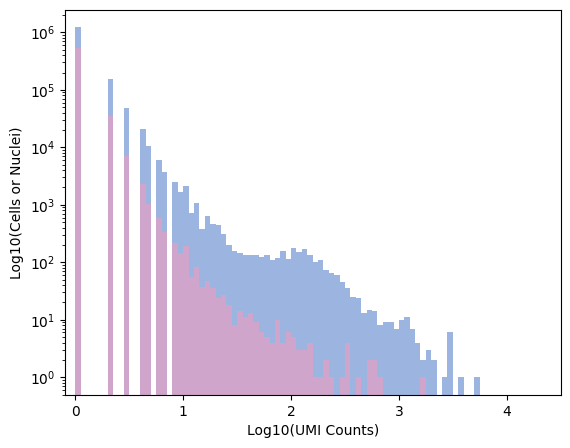

In [18]:
plt.figure().set_figheight(5)

maximum=np.log10(real_cell['UMI_Count']).max()
plt.hist(np.log10(real_cell['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#7294d4',alpha=0.7)
maximum=np.log10(real_nuc['UMI_Count']).max()
plt.hist(np.log10(real_nuc['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#e6a0c4',alpha=0.7)

plt.xlabel('Log10(UMI Counts)')
plt.ylabel('Log10(Cells or Nuclei)')
plt.xlim([-.1, 4.5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_6/combo_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

### Log10(Summed UMIs)

Get some stats on the distribution:

In [8]:
#Make UMI count-summed dataframes
summed_nuc=pd.DataFrame(real_nuc.groupby('CBC')['UMI_Count'].sum())
summed_cell=pd.DataFrame(real_cell.groupby('CBC')['UMI_Count'].sum())

print()
print('Wilcoxon Ranked Sum to compare distributions:')

nuc_dist = summed_nuc['UMI_Count']
cell_dist = summed_cell['UMI_Count']

print('Nuc mean:')
print((nuc_dist.mean()))
print('Nuc median:')
print((nuc_dist.median()))
print('Nuc SEM:')
print(nuc_dist.sem())
print('Cell mean:')
print(cell_dist.mean())
print('Cell median:')
print((cell_dist.median()))
print('Cell SEM:')
print(cell_dist.sem())

print('Wilcoxon Ranked Sum Results:')
print(ranksums(nuc_dist, cell_dist))


Wilcoxon Ranked Sum to compare distributions:
Nuc mean:
92.84828622149392
Nuc median:
79.0
Nuc SEM:
0.9757557809919087
Cell mean:
178.94283822555727
Cell median:
128.0
Cell SEM:
1.5722557684699907
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-64.31154531033344, pvalue=0.0)


Plot distribution comparison:

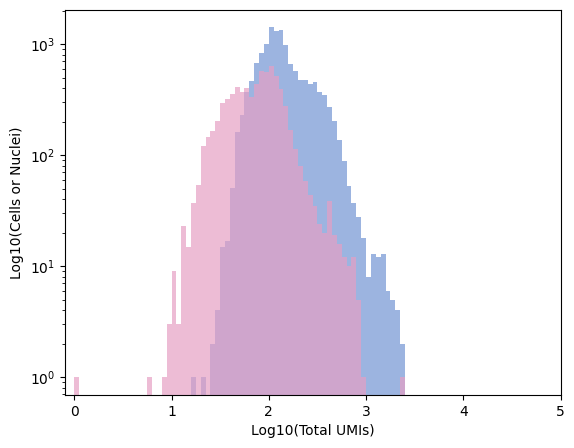

In [20]:
plt.figure().set_figheight(5)

maximum=np.log10(summed_nuc['UMI_Count']).max()
plt.hist(np.log10(summed_cell['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#7294d4',alpha=0.7)
maximum=np.log10(summed_nuc['UMI_Count']).max()
plt.hist(np.log10(summed_nuc['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#e6a0c4',alpha=0.7)


plt.xlabel('Log10(Total UMIs)')
plt.ylabel('Log10(Cells or Nuclei)')
plt.xlim([-.1, 5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_6/total_counts_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

### Log10(Summed UMIs vs. Unique Barcodes)

Drop any barcodes not passing UMI threshold of 2

In [9]:
real_nuc.drop(real_nuc[real_nuc['UMI_Count'] < 2].index, inplace=True)
real_cell.drop(real_cell[real_cell['UMI_Count'] < 2].index, inplace=True)

Format data for input into stats and plot

In [12]:
cell_mergeddf

,CBC,UMI_Count,barcode
0,c1_AAAAAAAAATCGCAGA,11,5
1,c1_AAAAAAACCCTCCCAA,16,4
2,c1_AAAAAACAAGCTAAGC,13,6
3,c1_AAAAAAGCATGGAGGT,64,17
4,c1_AAAAAAGTAGATCAAA,41,12
...,...,...,...
13514,c4_CCTTCCATAAATCCCT,128,43
13515,c4_CCTTCCCTACCCCACT,242,83
13516,c4_CCTTCCGAAGGCATAT,94,42
13517,c4_CCTTCCGCAACACCCT,94,37


In [11]:
nuc_total_umis=(real_nuc.groupby(['CBC'], as_index=False)['UMI_Count'].sum())
nuc_uniq_bcs=(real_nuc.groupby(['CBC'], as_index=False)['barcode'].nunique())
nuc_mergeddf = pd.merge(nuc_total_umis, nuc_uniq_bcs, on ='CBC')

cell_total_umis=(real_cell.groupby(['CBC'], as_index=False)['UMI_Count'].sum())
cell_uniq_bcs=(real_cell.groupby(['CBC'], as_index=False)['barcode'].nunique())
cell_mergeddf = pd.merge(cell_total_umis, cell_uniq_bcs, on ='CBC')
nuc_mergeddf

,CBC,UMI_Count,barcode
0,n1_AAAAAAATATGTAGCC,2,1
1,n1_AAAAAATACCAAAATG,19,6
2,n1_AAAAAATCCCTGAGAA,12,6
3,n1_AAAAAATGAGGCAATG,45,6
4,n1_AAAAAATGATGGAGCA,24,5
...,...,...,...
6935,n4_CCTTACCTCCTCCCTA,4,2
6936,n4_CCTTACGGACAAAAGG,8,4
6937,n4_CCTTCAGTCACTAAGG,12,5
6938,n4_CCTTCCAGACGTCAGG,2,1


Get some stats on this comparison

In [11]:
corr_matrix = np.corrcoef(np.log10(nuc_mergeddf['UMI_Count']), np.log10(nuc_mergeddf['barcode']))
print(stats.spearmanr(np.log10(nuc_mergeddf['UMI_Count']), np.log10(nuc_mergeddf['barcode']),nan_policy="omit"))
corr = corr_matrix[0,1]
R_sq = corr**2
print('Nuc r_squared:')
print(R_sq)
print()

corr_matrix = np.corrcoef(np.log10(cell_mergeddf['UMI_Count']), np.log10(cell_mergeddf['barcode']))
print(stats.spearmanr(np.log10(cell_mergeddf['UMI_Count']), np.log10(cell_mergeddf['barcode']),nan_policy="omit"))
corr = corr_matrix[0,1]
R_sq = corr**2
print('Cell r_squared:')
print(R_sq)

SignificanceResult(statistic=0.9151776030067437, pvalue=0.0)
Nuc r_squared:
0.8320578222065115

SignificanceResult(statistic=0.8134574096023549, pvalue=0.0)
Cell r_squared:
0.6632707565605683


Plot comparisons

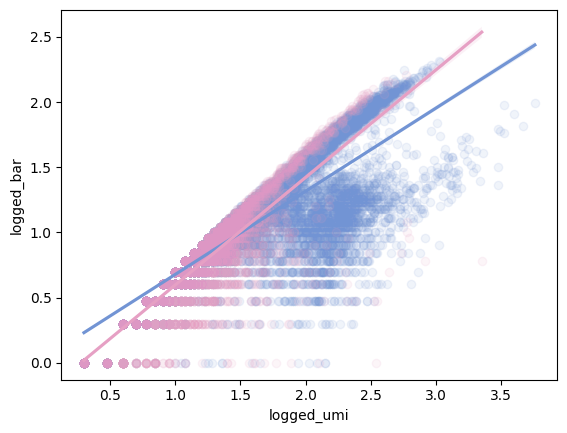

In [13]:
nuc_mergeddf['logged_umi']=np.log10(nuc_mergeddf['UMI_Count'])
nuc_mergeddf['logged_bar']=np.log10(nuc_mergeddf['barcode'])

cell_mergeddf['logged_umi']=np.log10(cell_mergeddf['UMI_Count'])
cell_mergeddf['logged_bar']=np.log10(cell_mergeddf['barcode'])
sns.regplot(data=cell_mergeddf, x='logged_umi', y='logged_bar', color = '#7294d4',scatter_kws={'alpha':0.1})
ax=sns.regplot(data=nuc_mergeddf, x='logged_umi', y='logged_bar', color = '#e6a0c4',scatter_kws={'alpha':0.1})

ax.figure.savefig("../figs/fig_6/total_vs_unique.png")

## Transcriptomic comparisons

### Plot cell and nuclei clusters separately

Separate datasets out from metadata table

In [24]:
#Pull metadata rows for cell vs. nuc datasets
cell_datasets=['c1','c2','c3','c4']
cell_metadata = metadata.loc[metadata['datasetid'].isin(cell_datasets)]
nuc_datasets=['n1','n2','n3','n4']
nuc_metadata = metadata.loc[metadata['datasetid'].isin(nuc_datasets)]

#Also pull metadata rows for pooled whole cell and nuc, uninfected datasets
uninf_cell_metadata = metadata.loc[metadata['datasetid'] == 'u1']
uninf_nuc_metadata = metadata.loc[metadata['datasetid'] == 'u2']
uninf_nuc_metadata

,Unnamed: 0,cellbarcode,celltype,datasetid
34403,34403,u2_AAAAAAAACCGGATAC,EN-L2_3-IT,u2
34404,34404,u2_AAAAAAACAGTGAGGC,EN-Newborn,u2
34405,34405,u2_AAAAAAACATTTAGAT,Unknown,u2
34406,34406,u2_AAAAAAAGATACAAAC,Oligodendrocyte,u2
34407,34407,u2_AAAAAAAGATTCACGC,EN-L2_3-IT,u2
...,...,...,...,...
46824,46824,u2_CCTTCCGTCCCTAAAT,EN-L2_3-IT,u2
46825,46825,u2_CCTTCCTACATACCAT,EN-L2_3-IT,u2
46826,46826,u2_CCTTCCTCAACCAAAG,EN-L2_3-IT,u2
46827,46827,u2_CCTTCCTCCCATACCA,RG-oRG,u2


### Stacked bar plot of cell type proportions across datasets

Calculate cell type proportions across each dataset

In [4]:
#Adding subclass to metadata
#Add some additional levels of cell type assignment (broad+subclasses)
clusters=metadata['celltype'].unique()

#Define subclasses (layer identies for excitatory neurons, types for glia, region for inhibitory)
astro=['Astrocyte-Fibrous','Astrocyte-Protoplasmic','Astrocyte-Immature']
opc=['OPC','Oligodendrocyte','Oligodendrocyte-Immature']
rgc=['RG-tRG','RG-oRG','RG-vRG']

pro=['IPC-EN','Tri-IPC']

mge=['IN-MGE-SST','IN-MGE-PV','IN-MGE-Immature']
cge=['IN-CGE-Immature','IN-CGE-VIP', 'IN-CGE-SNCG']
dge=['IN-NCx_dGE-Immature']

immature=['EN-Newborn','EN-IT-Immature','EN-Non-IT-Immature']
deep=['EN-L5_6-NP','EN-L6b','EN-L5-ET','EN-L6-CT', 'EN-L6-IT','EN-L5-IT']

metadata['subclass']=metadata['celltype'].copy()
metadata.loc[metadata['celltype'].isin(astro), 'subclass'] = 'Astrocyte'
metadata.loc[metadata['celltype'].isin(opc), 'subclass'] = 'Oligo'
metadata.loc[metadata['celltype'].isin(rgc), 'subclass'] = 'RG'
metadata.loc[metadata['celltype'].isin(pro), 'subclass'] = 'IPC'
metadata.loc[metadata['celltype'].isin(mge), 'subclass'] = 'IN-MGE'
metadata.loc[metadata['celltype'].isin(cge), 'subclass'] = 'IN-CGE'
metadata.loc[metadata['celltype'].isin(dge), 'subclass'] = 'IN-DGE'
metadata.loc[metadata['celltype'].isin(immature), 'subclass'] = 'EN-Immature'
metadata.loc[metadata['celltype'].isin(deep), 'subclass'] = 'EN-Deep Layer'

In [8]:
#Subset metadata down to cell types used for connectivity analysis
subset_metadata=metadata.loc[metadata.subclass != 'Unknown']
subset_metadata=subset_metadata.loc[subset_metadata.subclass != 'Microglia']
subset_metadata=subset_metadata.loc[subset_metadata.subclass != 'Vascular']
subset_metadata=subset_metadata.loc[subset_metadata.subclass != 'IN-Mix-LAMP5']

In [11]:
def calculate_props(dataset_list #list of dataset IDs to be pulled from metadata file
                   ):
    
    final_props=subset_metadata[['subclass']]
    final_props=final_props.drop_duplicates().reset_index()

    for i in dataset_list:
        temp = subset_metadata.loc[subset_metadata['datasetid'] == i]
        props=pd.DataFrame(temp['subclass'].value_counts()).reset_index()
        props[f'{i}_proportion']=props['count']/props['count'].sum()
        final_props = final_props.merge(props[['subclass', f'{i}_proportion']], on='subclass', how='left')

    transposed_props=final_props.T
    transposed_props.columns = transposed_props.iloc[1]
    transposed_props = transposed_props[2:]

    #Drop unknown columns
    transposed_props= transposed_props.fillna(0)
    
    return transposed_props


In [17]:
#Run calculate_props() function for paired slice datasets
dataset_list=['c1','c2','c3','c4','u1','n1','n2','n3','n4','u2']
final_props=calculate_props(dataset_list)
final_props

subclass,EN-Immature,IPC,IN-MGE,Astrocyte,IN-DGE,Oligo,EN-L2_3-IT,EN-L4-IT,RG,IN-CGE,Cajal-Retzius cell,EN-Deep Layer
c1_proportion,0.257378,0.014323,0.020833,0.112413,0.009549,0.029948,0.221788,0.170573,0.013889,0.013889,0.000868,0.134549
c2_proportion,0.485520,0.009807,0.073036,0.010269,0.011076,0.009346,0.287643,0.074997,0.003346,0.033806,0.000231,0.000923
c3_proportion,0.004049,0.000000,0.004049,0.001012,0.000000,0.190283,0.007085,0.003036,0.000000,0.006073,0.727733,0.056680
c4_proportion,0.045000,0.000000,0.006667,0.009167,0.000000,0.154167,0.032500,0.105000,0.000000,0.006667,0.560000,0.080833
u1_proportion,0.253390,0.085632,0.026817,0.194271,0.033521,0.012342,0.140332,0.109096,0.094317,0.015542,0.000914,0.033826
n1_proportion,0.140545,0.002555,0.009370,0.018739,0.005963,0.010221,0.679302,0.109029,0.003407,0.005111,0.006814,0.008944
n2_proportion,0.076823,0.008464,0.022786,0.023438,0.005859,0.037109,0.452474,0.046875,0.013672,0.014323,0.270833,0.027344
n3_proportion,0.070246,0.003132,0.004027,0.012081,0.000000,0.065324,0.119463,0.057718,0.004474,0.005817,0.217450,0.440268
n4_proportion,0.091825,0.006719,0.017917,0.019037,0.006719,0.066069,0.218365,0.089586,0.010078,0.021277,0.285554,0.166853
u2_proportion,0.153743,0.009905,0.015080,0.052735,0.007674,0.097885,0.422593,0.165343,0.012135,0.007138,0.047560,0.008209


In [18]:
#Sort cell types for input into stacked bar plot
final_props=final_props[['Oligo',
                         'Astrocyte',
                         'RG',
                         'IPC',
                         'EN-Immature',
                         'EN-L2_3-IT',
                         'EN-L4-IT',
                         'EN-Deep Layer',
                         'Cajal-Retzius cell',
                         'IN-CGE',
                         'IN-MGE',
                         'IN-DGE'
                        ]]
final_props['dataset'] = final_props.index

Plot stacked bar plot for each dataset

In [21]:
#Set up plotting parameters
plt.rcParams['figure.figsize'] = [0.5,0.5]
plt.rc('font', family='Arial')
sc.set_figure_params(dpi=50, dpi_save=1000)

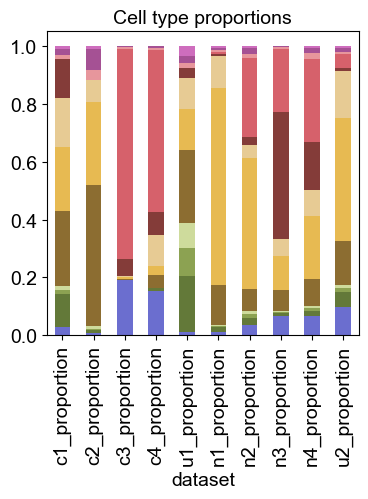

In [24]:
# plot data in stack manner of bar type



cell_type_palette=['#637939', #astro
                   '#d6616b', #CR
                   '#843c39', #Deep
                   '#8c6d31', #Immature
                   '#e7ba52', #L2/3
                   '#e7cb94',#L4
                   '#e7969c',#CGE
                   '#ce6dbd',#dlge
                   '#a55194',#mge
                   '#cedb9c',#ipc
                   '#6b6ecf',#oligo
                   '#8ca252']#rg



cell_type_palette=['#6b6ecf',
                  '#637939',
                  '#8ca252',
                  '#cedb9c',
                  '#8c6d31',
                  '#e7ba52',
                  '#e7cb94',
                  '#843c39',
                  '#d6616b',
                  '#e7969c',
                  '#a55194',
                  '#ce6dbd']#rg


final_props.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=False,
                 color=cell_type_palette
                )

plt.grid(None)
plt.savefig('../figs/fig_6/stacked_cell_types.pdf', bbox_inches='tight', format='pdf')
plt.show()
